In [ ]:
from notebooks import *

In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[23:27:24.814] DEBUG  Projection.load
  path: /app/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (recs/sp)' % (desc, '%s/%s' % (len(df), df.species.nunique()))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[35k/334 -> 25k/127 -> 21k/100 ->  10k/100 ->  10k/100]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[35k/334 -> 32k/224 -> 16k/100 -> 9.0k/100 -> 9.0k/100]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[35k/334 -> 35k/334 -> 12k/100 -> 6.8k/100 -> 6.8k/ 99]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[34k/334 -> 34k/334 -> 18k/168 ->  11k/168 ->  11k/167]  # compare.ipynb all
recs_at_least, num_species, num_recs =   0, 168,  20  # ca[34k/334 -> 35k/334 -> 18k/168 ->  3.2/168 ->  3.2/167]  # compare.ipynb recs
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
display(
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              399859/9442 (recs/sp)
countries         59713/1148 (recs/sp)
com_names          35236/334 (recs/sp)
(downloaded)       35228/334 (recs/sp)
recs_at_least      35228/334 (recs/sp)
num_species        18186/168 (recs/sp)


num_recs            3194/168 (recs/sp)
recs ≥ 2            3193/167 (recs/sp)


,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,89404,3193,3193,1,NaN,NaN,True,True,True,True,True
species,category,169239,3193,3193,167,NaN,NaN,GWFG,GWGU,TRKI,PHAI,PTWH
id,int64,89404,3193,3193,3193,213695.183,106768.668,1137,138717,196881,304679,416741
sci_name,category,214049,3193,3193,167,NaN,NaN,Anser albifrons,Larus glaucescens,Tyrannus melancholicus,Phainopepla nitens,Vidua macroura
com_name,category,207988,3193,3193,167,NaN,NaN,Greater White-fronted Goose,Glaucous-winged Gull,Tropical Kingbird,Phainopepla,Pin-tailed Whydah
subspecies,object,161265,3193,3193,200,NaN,NaN,,,,,zaboria
recordist,object,201381,3193,3193,278,NaN,NaN,Aaron Boone,Frank Lambert,Mike Nelson,Phoenix Birder,patrice adret
country,object,193199,3193,3193,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,301742,3193,3193,1621,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Derby Creek, Council Road, Nome Census Area, Alaska","Melody Temple Grove, Bent County, Colorado","Saint-Louis-de-Gonzague, Beauharnois-Salaberry Regional County Municipality, Quebec","western Apalachicola National Forest, Florida"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
WFIB,63798,True,WFIB,352723,Plegadis chihi,White-faced Ibis,,Frank Lambert,Mexico,"Laguna Zapotlán, Jalisco",19.8,-103.0,flight call,C,2015-04-07 00:00:00,08:53,by-nc-nd,4.0,//creativecommons.org/licenses/by-nc-nd/4.0/,https://www.xeno-canto.org/352723,//www.xeno-canto.org/352723/download
AMAV,270065,True,AMAV,139921,Recurvirostra americana,American Avocet,,GABRIEL LEITE,United States,"University of Wyoming (near Laramie), Albany, Wyoming",41.3,-106.0,call,C,2013-05-07 00:00:00,11:00,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/139921,//www.xeno-canto.org/139921/download
BLOY,374555,True,BLOY,28274,Haematopus bachmani,Black Oystercatcher,,Andrew Spencer,United States,"West Cliff Drive, Santa Cruz, Santa Cruz Co., California",37.0,-122.0,call,B,2009-01-12 00:00:00,14:00,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/28274,//www.xeno-canto.org/28274/download
SEPL,260709,True,SEPL,149624,Charadrius semipalmatus,Semipalmated Plover,,Paul Marvin,United States,"Biolab Road, Canaveral National Seashore, Brevard County, Florida",28.7,-80.7,call,A,2013-09-15 00:00:00,07:38,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/149624,//www.xeno-canto.org/149624/download
RNPH,208621,True,RNPH,203600,Phalaropus lobatus,Red-necked Phalarope,,Andrew Spencer,United States,"Dalton Highway, Pump Station 4 access road, North Slope Borough, Alaska",68.4,-149.0,call,A,2014-07-01 00:00:00,09:45,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/203600,//www.xeno-canto.org/203600/download
MODO,246559,True,MODO,164123,Zenaida macroura,Mourning Dove,,Patrick Turgeon,Canada,"Foam Lake No. 276 (near Leslie), Division No. 10, Saskatchewan",51.8,-104.0,song,B,2013-07-09 00:00:00,06:02,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/164123,//www.xeno-canto.org/164123/download
LCPA,63318,True,LCPA,353205,Amazona finschi,Lilac-crowned Amazon,,Richard E. Webster,Mexico,"Arroyo La Aduana, Álamos, Sonora",27.0,-109.0,call,B,2016-03-20 00:00:00,10:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/353205,//www.xeno-canto.org/353205/download
BTMJ,16529,True,BTMJ,400960,Calocitta colliei,Black-throated Magpie-Jay,,Richard E. Webster,Mexico,"Minas Nuevas, Álamos, Sonora",27.1,-109.0,call,A,2014-12-22 00:00:00,10:27,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/400960,//www.xeno-canto.org/400960/download
SATH,389358,True,SATH,12118,Oreoscoptes montanus,Sage Thrasher,,Nathan Pieplow,United States,"Mack, Mesa County, Colorado",39.2,-109.0,song,A,2007-04-07 00:00:00,11:30,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/12118,//www.xeno-canto.org/12118/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    xcs_paths[:10],
)

3193

[
    ('xc', '/app/data/xc/data/GWFG/149379/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/160186/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/276916/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/149380/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/153074/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/276917/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/294804/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/406248/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/276921/audio.mp3'),
    ('xc', '/app/data/xc/data/GWFG/149381/audio.mp3')
]

In [ ]:
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,162690,3190,3190,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,169080,3190,3190,167,NaN,NaN,GWFG,GWGU,TRKI,PHAI,PTWH
species_com_name,category,207084,3190,3190,167,NaN,NaN,Greater White-fronted Goose,Glaucous-winged Gull,Tropical Kingbird,Phainopepla,Pin-tailed Whydah
species_query,object,169080,3190,3190,167,NaN,NaN,ABTO,CATH,LBDO,RNPH,yecpar
duration_s,float64,76560,3190,3190,2880,5.185e+01,6.766e+01,0.697,13.4,30,61.8,650
samples_mb,float64,76560,3190,3190,2881,2.193e+00,2.851e+00,0.0293,0.565,1.26,2.61,27.4
samples_n,int64,89320,3190,3190,2881,1.150e+06,1.495e+06,15368,296166,662400,1368511,14341888
basename,object,172260,3190,3190,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,229424,3190,3190,167,NaN,NaN,Greater White-fronted Goose - GWFG,Glaucous-winged Gull - GWGU,Tropical Kingbird - TRKI,Phainopepla - PHAI,Pin-tailed Whydah - PTWH


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)  # Order species by count
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    # .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset), ordered by count')
)

[skip]

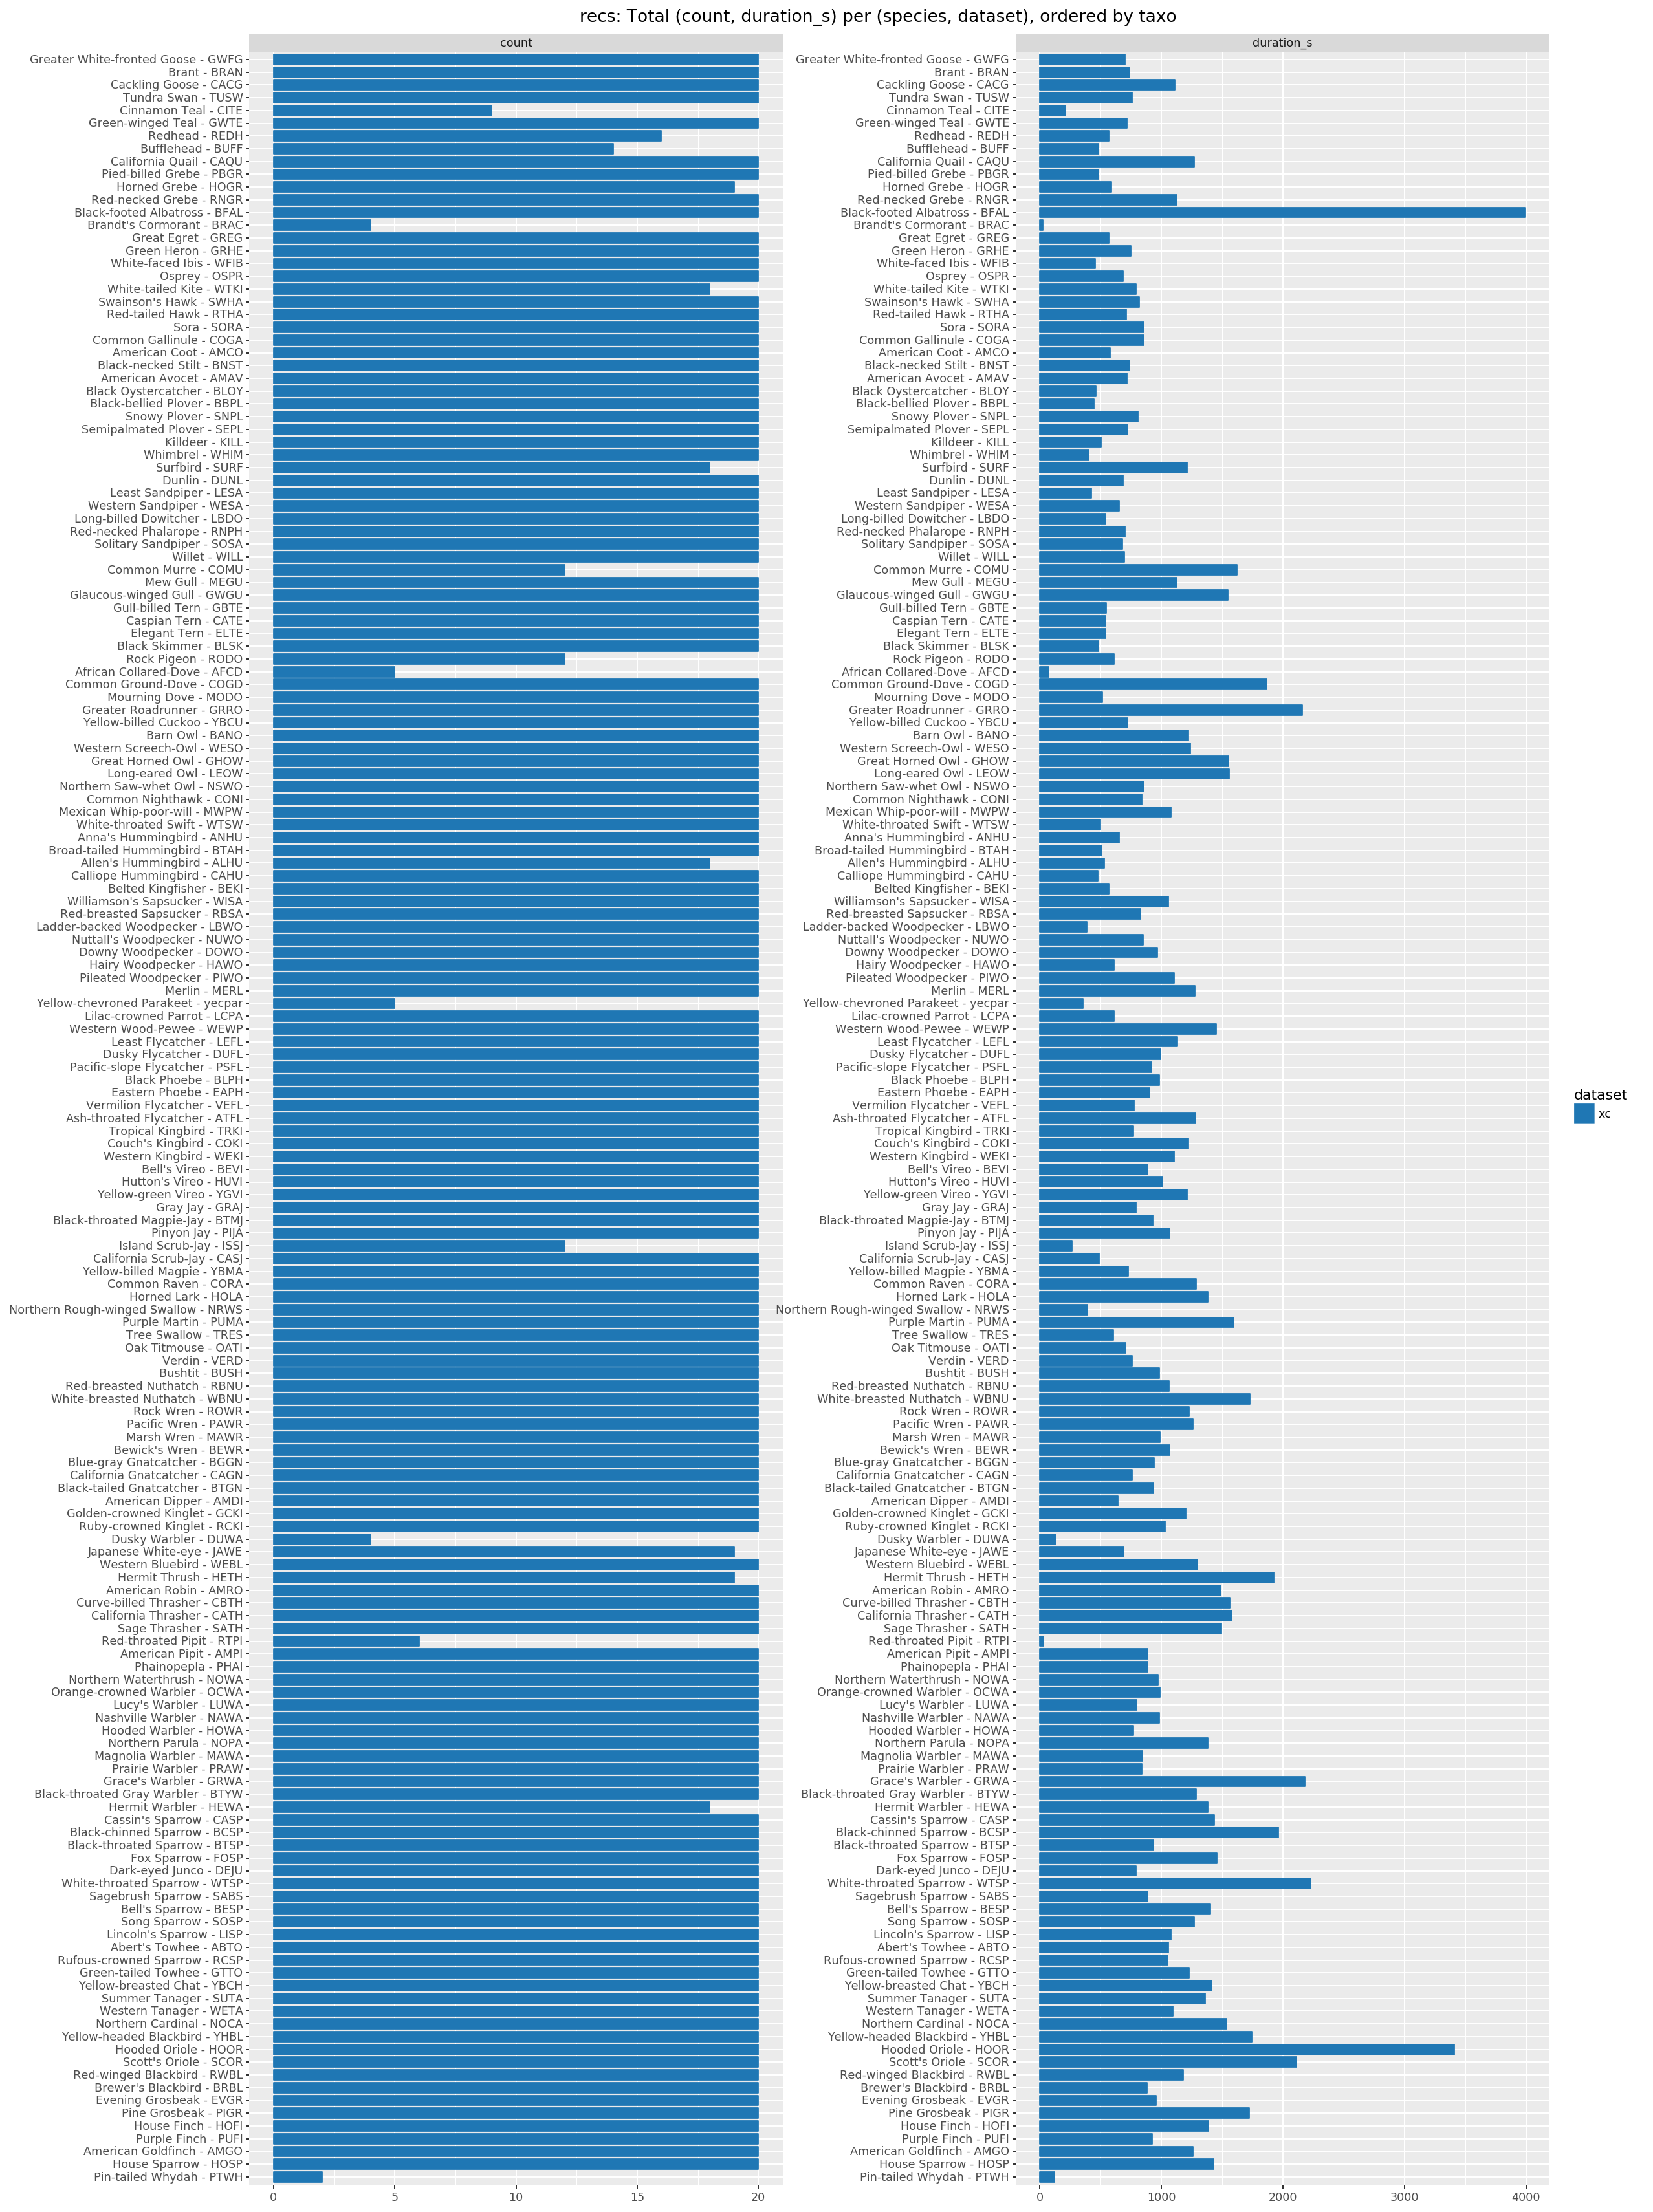

<ggplot: (8740524347961)>

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    # .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset), ordered by taxo')
)

In [ ]:
# Add .feat
recs = projection.transform(recs)

[                                                                                                       ] | 0% Completed |  0.0s

[                                                                                                       ] | 0% Completed |  0.1s

[                                                                                                       ] | 0% Completed |  0.3s

[                                                                                                       ] | 0% Completed |  0.4s

[#                                                                                                      ] | 1% Completed |  0.5s

[#                                                                                                      ] | 1% Completed |  0.6s

[#                                                                                                      ] | 1% Completed |  0.7s

[#                                                                                                      ] | 1% Completed |  0.8s

[##                                                                                                     ] | 2% Completed |  0.9s

[##                                                                                                     ] | 2% Completed |  1.0s

[###                                                                                                    ] | 3% Completed |  1.1s

[###                                                                                                    ] | 3% Completed |  1.2s

[###                                                                                                    ] | 3% Completed |  1.3s

[####                                                                                                   ] | 4% Completed |  1.4s

[####                                                                                                   ] | 4% Completed |  1.5s

[#####                                                                                                  ] | 5% Completed |  1.6s

[#####                                                                                                  ] | 5% Completed |  1.7s

[######                                                                                                 ] | 6% Completed |  1.8s

[######                                                                                                 ] | 6% Completed |  1.9s

[#######                                                                                                ] | 6% Completed |  2.0s

[#######                                                                                                ] | 6% Completed |  2.1s

[#######                                                                                                ] | 7% Completed |  2.2s

[#######                                                                                                ] | 7% Completed |  2.3s

[########                                                                                               ] | 7% Completed |  2.5s

[########                                                                                               ] | 8% Completed |  2.6s

[#########                                                                                              ] | 9% Completed |  2.7s

[#########                                                                                              ] | 9% Completed |  2.8s

[##########                                                                                             ] | 10% Completed |  2.9s

[##########                                                                                             ] | 10% Completed |  3.0s

[###########                                                                                            ] | 10% Completed |  3.1s

[###########                                                                                            ] | 11% Completed |  3.2s

[############                                                                                           ] | 11% Completed |  3.3s

[############                                                                                           ] | 11% Completed |  3.4s

[############                                                                                           ] | 12% Completed |  3.5s

[############                                                                                           ] | 12% Completed |  3.6s

[#############                                                                                          ] | 13% Completed |  3.7s

[##############                                                                                         ] | 13% Completed |  3.8s

[##############                                                                                         ] | 14% Completed |  3.9s

[###############                                                                                        ] | 14% Completed |  4.0s

[###############                                                                                        ] | 15% Completed |  4.1s

[################                                                                                       ] | 16% Completed |  4.3s

[#################                                                                                      ] | 16% Completed |  4.4s

[##################                                                                                     ] | 17% Completed |  4.5s

[##################                                                                                     ] | 17% Completed |  4.6s

[###################                                                                                    ] | 18% Completed |  4.7s

[####################                                                                                   ] | 19% Completed |  4.8s

[####################                                                                                   ] | 19% Completed |  4.9s

[####################                                                                                   ] | 20% Completed |  5.0s

[#####################                                                                                  ] | 20% Completed |  5.1s

[#####################                                                                                  ] | 20% Completed |  5.2s

[#####################                                                                                  ] | 21% Completed |  5.3s

[######################                                                                                 ] | 21% Completed |  5.4s

[#######################                                                                                ] | 22% Completed |  5.5s

[#######################                                                                                ] | 23% Completed |  5.6s

[########################                                                                               ] | 23% Completed |  5.7s

[#########################                                                                              ] | 24% Completed |  5.8s

[#########################                                                                              ] | 25% Completed |  5.9s

[##########################                                                                             ] | 26% Completed |  6.0s

[###########################                                                                            ] | 26% Completed |  6.1s

[###########################                                                                            ] | 26% Completed |  6.2s

[############################                                                                           ] | 27% Completed |  6.3s

[#############################                                                                          ] | 28% Completed |  6.5s

[##############################                                                                         ] | 29% Completed |  6.6s

[##############################                                                                         ] | 29% Completed |  6.7s

[##############################                                                                         ] | 29% Completed |  6.8s

[##############################                                                                         ] | 29% Completed |  6.9s

[##############################                                                                         ] | 29% Completed |  7.0s

[###############################                                                                        ] | 30% Completed |  7.1s

[###############################                                                                        ] | 30% Completed |  7.2s

[###############################                                                                        ] | 31% Completed |  7.3s

[################################                                                                       ] | 31% Completed |  7.4s

[################################                                                                       ] | 31% Completed |  7.5s

[#################################                                                                      ] | 32% Completed |  7.6s

[#################################                                                                      ] | 32% Completed |  7.7s

[#################################                                                                      ] | 32% Completed |  7.8s

[##################################                                                                     ] | 33% Completed |  7.9s

[##################################                                                                     ] | 33% Completed |  8.0s

[###################################                                                                    ] | 34% Completed |  8.1s

[###################################                                                                    ] | 34% Completed |  8.2s

[####################################                                                                   ] | 35% Completed |  8.3s

[####################################                                                                   ] | 35% Completed |  8.4s

[#####################################                                                                  ] | 36% Completed |  8.5s

[######################################                                                                 ] | 36% Completed |  8.6s

[######################################                                                                 ] | 37% Completed |  8.7s

[######################################                                                                 ] | 37% Completed |  8.8s

[#######################################                                                                ] | 38% Completed |  8.9s

[########################################                                                               ] | 38% Completed |  9.0s

[########################################                                                               ] | 39% Completed |  9.1s

[#########################################                                                              ] | 39% Completed |  9.3s

[#########################################                                                              ] | 40% Completed |  9.4s

[#########################################                                                              ] | 40% Completed |  9.5s

[##########################################                                                             ] | 41% Completed |  9.6s

[##########################################                                                             ] | 41% Completed |  9.7s

[###########################################                                                            ] | 42% Completed |  9.8s

[############################################                                                           ] | 42% Completed |  9.9s

[############################################                                                           ] | 42% Completed | 10.0s

[#############################################                                                          ] | 43% Completed | 10.1s

[#############################################                                                          ] | 44% Completed | 10.2s

[#############################################                                                          ] | 44% Completed | 10.3s

[##############################################                                                         ] | 44% Completed | 10.4s

[##############################################                                                         ] | 44% Completed | 10.5s

[##############################################                                                         ] | 45% Completed | 10.6s

[###############################################                                                        ] | 46% Completed | 10.7s

[###############################################                                                        ] | 46% Completed | 10.8s

[###############################################                                                        ] | 46% Completed | 10.9s

[################################################                                                       ] | 46% Completed | 11.0s

[################################################                                                       ] | 47% Completed | 11.1s

[#################################################                                                      ] | 47% Completed | 11.2s

[#################################################                                                      ] | 48% Completed | 11.3s

[##################################################                                                     ] | 48% Completed | 11.4s

[##################################################                                                     ] | 48% Completed | 11.5s

[###################################################                                                    ] | 49% Completed | 11.6s

[###################################################                                                    ] | 49% Completed | 11.7s

[###################################################                                                    ] | 50% Completed | 11.9s

[####################################################                                                   ] | 51% Completed | 12.0s

[####################################################                                                   ] | 51% Completed | 12.1s

[####################################################                                                   ] | 51% Completed | 12.2s

[#####################################################                                                  ] | 51% Completed | 12.3s

[#####################################################                                                  ] | 52% Completed | 12.4s

[######################################################                                                 ] | 52% Completed | 12.5s

[######################################################                                                 ] | 52% Completed | 12.6s

[######################################################                                                 ] | 53% Completed | 12.7s

[#######################################################                                                ] | 54% Completed | 12.8s

[########################################################                                               ] | 54% Completed | 12.9s

[########################################################                                               ] | 54% Completed | 13.0s

[########################################################                                               ] | 54% Completed | 13.1s

[#########################################################                                              ] | 55% Completed | 13.2s

[#########################################################                                              ] | 56% Completed | 13.3s

[##########################################################                                             ] | 56% Completed | 13.4s

[###########################################################                                            ] | 57% Completed | 13.6s

[###########################################################                                            ] | 57% Completed | 13.7s

[###########################################################                                            ] | 57% Completed | 13.8s

[############################################################                                           ] | 58% Completed | 13.9s

[############################################################                                           ] | 58% Completed | 14.0s

[#############################################################                                          ] | 59% Completed | 14.1s

[#############################################################                                          ] | 59% Completed | 14.2s

[#############################################################                                          ] | 60% Completed | 14.3s

[#############################################################                                          ] | 60% Completed | 14.4s

[##############################################################                                         ] | 60% Completed | 14.5s

[##############################################################                                         ] | 61% Completed | 14.6s

[###############################################################                                        ] | 61% Completed | 14.7s

[################################################################                                       ] | 62% Completed | 14.9s

[################################################################                                       ] | 62% Completed | 15.0s

[################################################################                                       ] | 62% Completed | 15.1s

[#################################################################                                      ] | 63% Completed | 15.2s

[#################################################################                                      ] | 63% Completed | 15.3s

[##################################################################                                     ] | 64% Completed | 15.4s

[##################################################################                                     ] | 64% Completed | 15.5s

[##################################################################                                     ] | 64% Completed | 15.6s

[###################################################################                                    ] | 65% Completed | 15.7s

[###################################################################                                    ] | 65% Completed | 15.8s

[####################################################################                                   ] | 66% Completed | 15.9s

[####################################################################                                   ] | 66% Completed | 16.0s

[#####################################################################                                  ] | 67% Completed | 16.1s

[#####################################################################                                  ] | 67% Completed | 16.2s

[######################################################################                                 ] | 68% Completed | 16.3s

[######################################################################                                 ] | 68% Completed | 16.4s

[######################################################################                                 ] | 68% Completed | 16.5s

[#######################################################################                                ] | 68% Completed | 16.6s

[#######################################################################                                ] | 69% Completed | 16.7s

[########################################################################                               ] | 69% Completed | 16.8s

[########################################################################                               ] | 70% Completed | 16.9s

[########################################################################                               ] | 70% Completed | 17.0s

[#########################################################################                              ] | 71% Completed | 17.1s

[#########################################################################                              ] | 71% Completed | 17.2s

[##########################################################################                             ] | 71% Completed | 17.3s

[##########################################################################                             ] | 72% Completed | 17.4s

[##########################################################################                             ] | 72% Completed | 17.5s

[###########################################################################                            ] | 73% Completed | 17.6s

[###########################################################################                            ] | 73% Completed | 17.8s

[############################################################################                           ] | 74% Completed | 17.9s

[############################################################################                           ] | 74% Completed | 18.0s

[############################################################################                           ] | 74% Completed | 18.1s

[#############################################################################                          ] | 75% Completed | 18.2s

[#############################################################################                          ] | 75% Completed | 18.3s

[#############################################################################                          ] | 75% Completed | 18.4s

[##############################################################################                         ] | 75% Completed | 18.5s

[##############################################################################                         ] | 76% Completed | 18.6s

[###############################################################################                        ] | 76% Completed | 18.7s

[###############################################################################                        ] | 77% Completed | 18.8s

[###############################################################################                        ] | 77% Completed | 18.9s

[################################################################################                       ] | 78% Completed | 19.0s

[################################################################################                       ] | 78% Completed | 19.1s

[################################################################################                       ] | 78% Completed | 19.2s

[#################################################################################                      ] | 79% Completed | 19.3s

[#################################################################################                      ] | 79% Completed | 19.4s

[##################################################################################                     ] | 79% Completed | 19.5s

[##################################################################################                     ] | 79% Completed | 19.6s

[##################################################################################                     ] | 80% Completed | 19.7s

[##################################################################################                     ] | 80% Completed | 19.8s

[###################################################################################                    ] | 80% Completed | 19.9s

[####################################################################################                   ] | 81% Completed | 20.0s

[####################################################################################                   ] | 82% Completed | 20.1s

[####################################################################################                   ] | 82% Completed | 20.2s

[#####################################################################################                  ] | 82% Completed | 20.3s

[#####################################################################################                  ] | 83% Completed | 20.4s

[#####################################################################################                  ] | 83% Completed | 20.5s

[######################################################################################                 ] | 84% Completed | 20.6s

[######################################################################################                 ] | 84% Completed | 20.8s

[#######################################################################################                ] | 84% Completed | 20.9s

[#######################################################################################                ] | 84% Completed | 21.0s

[#######################################################################################                ] | 84% Completed | 21.1s

[########################################################################################               ] | 85% Completed | 21.2s

[########################################################################################               ] | 85% Completed | 21.3s

[########################################################################################               ] | 86% Completed | 21.4s

[#########################################################################################              ] | 86% Completed | 21.5s

[#########################################################################################              ] | 87% Completed | 21.6s

[##########################################################################################             ] | 87% Completed | 21.7s

[##########################################################################################             ] | 88% Completed | 21.8s

[###########################################################################################            ] | 88% Completed | 21.9s

[###########################################################################################            ] | 89% Completed | 22.0s

[############################################################################################           ] | 89% Completed | 22.1s

[############################################################################################           ] | 89% Completed | 22.2s

[############################################################################################           ] | 90% Completed | 22.3s

[#############################################################################################          ] | 91% Completed | 22.4s

[##############################################################################################         ] | 91% Completed | 22.5s

[##############################################################################################         ] | 92% Completed | 22.6s

[###############################################################################################        ] | 92% Completed | 22.7s

[###############################################################################################        ] | 93% Completed | 22.8s

[################################################################################################       ] | 93% Completed | 22.9s

[################################################################################################       ] | 93% Completed | 23.0s

[################################################################################################       ] | 94% Completed | 23.1s

[#################################################################################################      ] | 94% Completed | 23.2s

[#################################################################################################      ] | 94% Completed | 23.3s

[##################################################################################################     ] | 95% Completed | 23.4s

[###################################################################################################    ] | 96% Completed | 23.5s

[###################################################################################################    ] | 96% Completed | 23.6s

[###################################################################################################    ] | 96% Completed | 23.8s

[####################################################################################################   ] | 97% Completed | 23.9s

[#####################################################################################################  ] | 98% Completed | 24.0s

[#####################################################################################################  ] | 98% Completed | 24.1s

[###################################################################################################### ] | 99% Completed | 24.2s

[###################################################################################################### ] | 99% Completed | 24.3s

[###################################################################################################### ] | 99% Completed | 24.4s

[#######################################################################################################] | 100% Completed | 24.5s

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # # KNN
        # #   - Bad for large k because we only have ~7-26 instances per class
        # #   - Bad for small k because KNN
        # # 'cls: knn, n_neighbors: 100',
        # 'cls: knn, n_neighbors: 50',
        # 'cls: knn, n_neighbors: 25',
        # # 'cls: knn, n_neighbors: 15',
        # 'cls: knn, n_neighbors: 10',
        # 'cls: knn, n_neighbors: 5',
        # 'cls: knn, n_neighbors: 3',
        # 'cls: knn, n_neighbors: 1',

        # # SVM(RBF)
        # #   - [SBF16] Uses these
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # [SBF16]
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',  # Same as C:10 [why?]
        # # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',  # Same as C:10 [why?]

        # # RandomForest(entropy)
        # #   - [SP14] uses entropy
        # # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 1000',

        # # RandomForest(gini)
        # #   - sk uses gini by default
        # #   - TODO Try 'class_weight: balanced' / 'class_weight: balanced_subsample'
        # #     - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        # #     - http://scikit-learn.org/stable/modules/tree.html#tree
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1',  # Faster dev
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',
        # WARNING These two are not very mem safe...
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1500',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 2000',

    ],
    # Downsample for learning curves
    downsample_classes=[
        # .1, # Faster dev
        # .1, 1.0,  # Faster dev
        100, 50,  # Faster dev
        # 100, 75, 50, 25,  # Biggest first, to fail fast
    ],
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=6,  # Doesn't peg all 8 hyperthreads
    # n_jobs=8,
    n_jobs=16,  # Not mem safe on laptop (16x rf classifiers)
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # FIXME Need to use sk.externals.joblib.parallel_backend instead of joblib.parallel_backend, since sk bundles joblib
    #   - http://dask-ml.readthedocs.io/en/latest/joblib.html
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect -- see comment]
    stack.enter_context(log.context(level='info'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[23:32:29.424] INFO   _fit_and_score... split_i[0], train[2552], test[638], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:29.461] INFO   _fit_and_score... split_i[1], train[2552], test[638], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:29.498] INFO   _fit_and_score... split_i[2], train[2552], test[638], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:29.533] INFO   _fit_and_score... split_i[0], train[2552], test[638], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:29.576] INFO   _fit_and_score... split_i[1], train[2552], test[638], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:29.621] INFO   _fit_and_score... split_i[2], train[2552], test[638], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:51.499] INFO   _fit_and_score[22.034s]: split_i[1], train[2552], test[638], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:51.623] INFO   _fit_and_score[22.118s]: split_i[2], train[2552], test[638], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:52.104] INFO   _fit_and_score[22.515s]: split_i[1], train[2552], test[638], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:52.184] INFO   _fit_and_score[22.557s]: split_i[2], train[2552], test[638], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[Parallel(n_jobs=16)]: Done   3 out of   6 | elapsed:   22.8s remaining:   22.8s


[23:32:52.366] INFO   _fit_and_score[22.813s]: split_i[0], train[2552], test[638], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[23:32:52.514] INFO   _fit_and_score[23.087s]: split_i[0], train[2552], test[638], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10', random_state=0)]


[Parallel(n_jobs=16)]: Done   6 out of   6 | elapsed:   23.2s finished


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: {
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_')},
        'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    }))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params
    .assign(
        # Useful for validation curves (vary params by classifier type)
        # classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
        #     '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
        #     x['cls']
        # )),
        # Useful for learning curves (vary downsample_classes per classifier)
        classifier_type=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, v) for k, v in d.items() if k not in ['downsample_classes']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
param_list = list(cv_models.params.unique())
display(
    df_summary(cv_models).T,
    # cv_models[:5],
    cv_models,
    param_list,
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,921,6,6,6.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]"
params,object,867,6,6,2.0,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]"
params_dict,object,1440,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
classifier_type,object,804,6,6,1.0,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,160,6,6,3.0,NaN,NaN,0,0,1,1,2
train_score,float64,144,6,6,1.0,NaN,NaN,-1,-1,-1,-1,-1
test_score,float64,144,6,6,1.0,NaN,NaN,-167,-167,-167,-167,-167
test_evals,object,5264526,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,model_id,params,params_dict,classifier_type,fold,train_score,test_score,test_evals
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 100}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,-1.0,-167.0,"SearchEvals(i[(638,)], y[(638,)], classes[(167,)], y_scores[(638, 167)])"
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 100}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",1,-1.0,-167.0,"SearchEvals(i[(638,)], y[(638,)], classes[(167,)], y_scores[(638, 167)])"
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 100}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",2,-1.0,-167.0,"SearchEvals(i[(638,)], y[(638,)], classes[(167,)], y_scores[(638, 167)])"
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,-1.0,-167.0,"SearchEvals(i[(638,)], y[(638,)], classes[(167,)], y_scores[(638, 167)])"
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",1,-1.0,-167.0,"SearchEvals(i[(638,)], y[(638,)], classes[(167,)], y_scores[(638, 167)])"
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","{'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",2,-1.0,-167.0,"SearchEvals(i[(638,)], y[(638,)], classes[(167,)], y_scores[(638, 167)])"


[
    'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: '
        '10], downsample_classes[100]',
    'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: '
        '10], downsample_classes[50]'
]

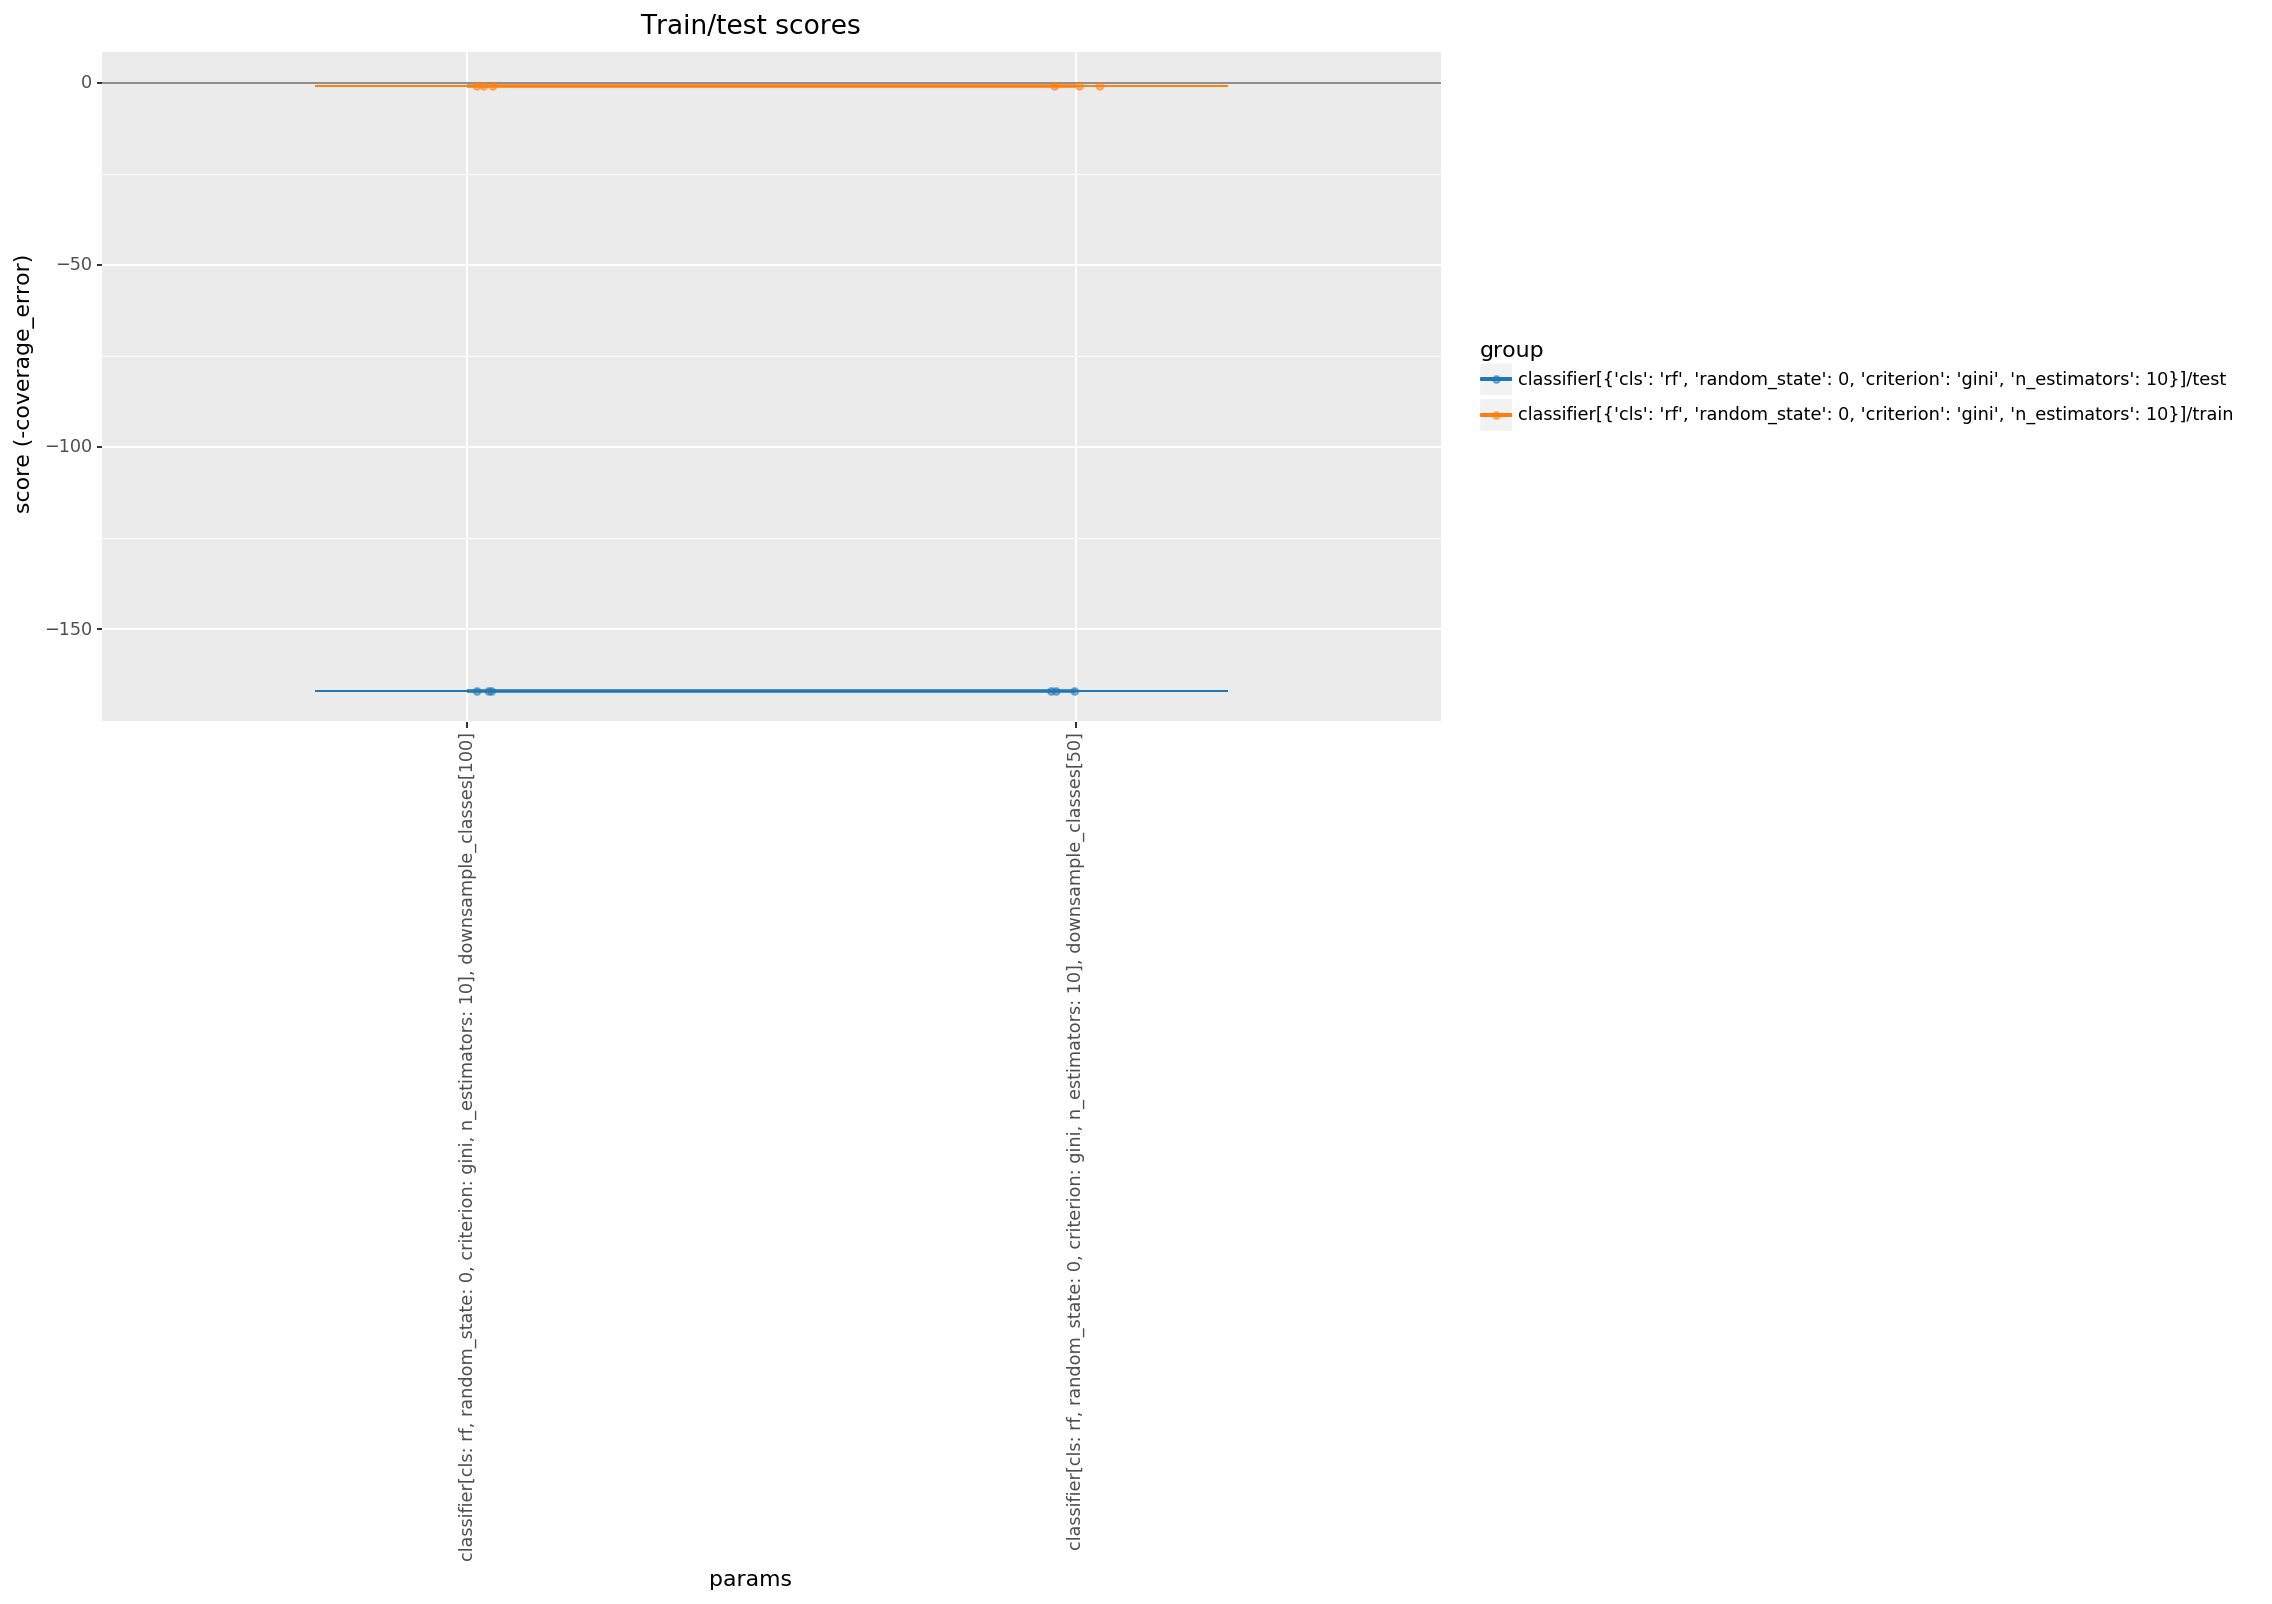

<ggplot: (-9223363296334405032)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.apply(axis=1, func=lambda row: row.classifier_type + '/' + row.split),
    )
    .pipe(df_ordered_cat, params=lambda df: param_list)
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05, height=1e-9)
    # + geom_point(alpha=.5)
    + geom_line(aes(group='group + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    # + coord_cartesian(ylim=(-35, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_list))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/2]
  fold[*/3]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████▏                                                                                | 1/6 [00:00<00:01,  2.90it/s]

 33%|████████████████████████████████▎                                                                | 2/6 [00:00<00:01,  2.82it/s]

 50%|████████████████████████████████████████████████▌                                                | 3/6 [00:01<00:01,  2.81it/s]

 67%|████████████████████████████████████████████████████████████████▋                                | 4/6 [00:01<00:00,  2.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▊                | 5/6 [00:01<00:00,  2.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.79it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,1935054,3828,3828,6,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]"
params,object,1785762,3828,3828,2,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]"
classifier_type,object,1610312,3828,3828,1,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,102080,3828,3828,3,NaN,NaN,0,0,1,2,2
i,int64,107176,3828,3828,1561,NaN,NaN,0,798,1595,2392,3183
y_true,object,325392,3828,3828,166,NaN,NaN,ABTO,CATH,KILL,RNGR,yecpar
coverage_error,float64,91872,3828,3828,9,NaN,NaN,1,9,167,167,167


,model_id,params,classifier_type,fold,i,y_true,coverage_error
0,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2937,WETA,167.0
1,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1405,yecpar,9.0
2,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2073,MAWR,167.0
3,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,56,CACG,8.0
4,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2798,SOSP,167.0
5,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2759,SABS,167.0
6,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1280,RBSA,167.0
7,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2310,CBTH,9.0
8,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2053,PAWR,167.0
9,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1125,MWPW,1.0


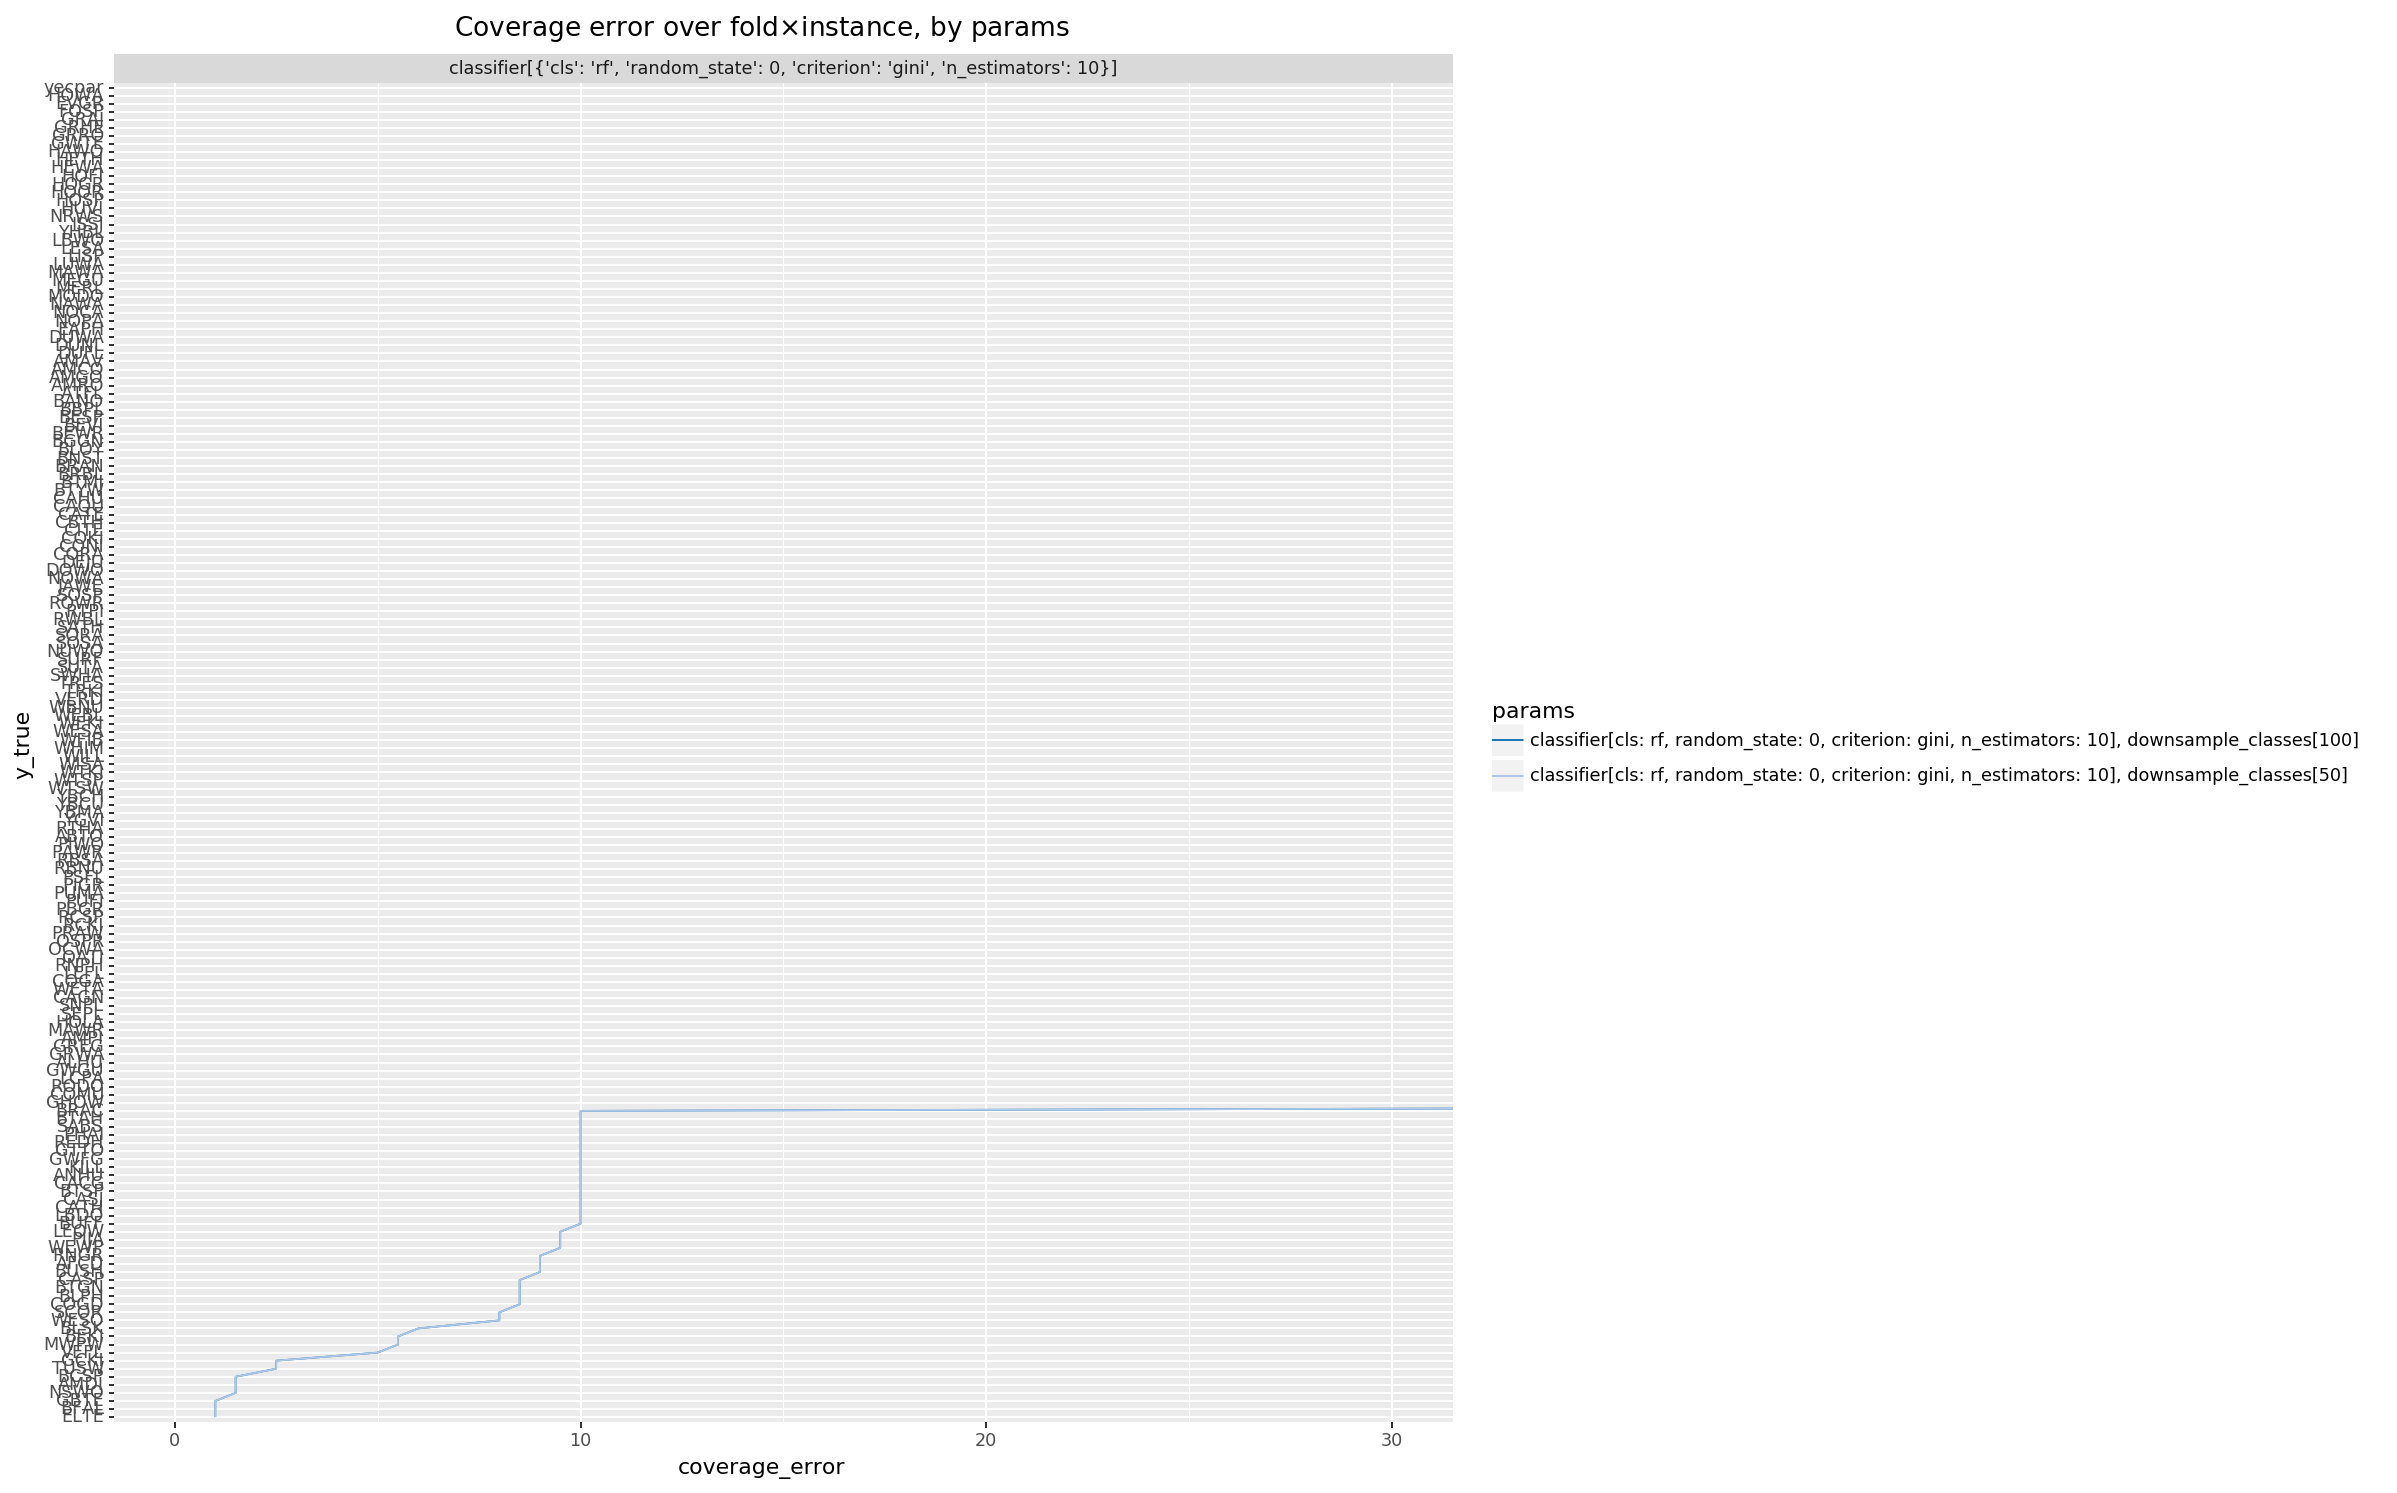

<ggplot: (-9223363296337206079)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # Sort species by median(coverage_error) (across all models)
    .pipe(df_ordered_cat, y_true=lambda df: (
        df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
    ))
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip(ylim=(0, min(30, len(np.unique(y)))))
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme_figsize('square')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

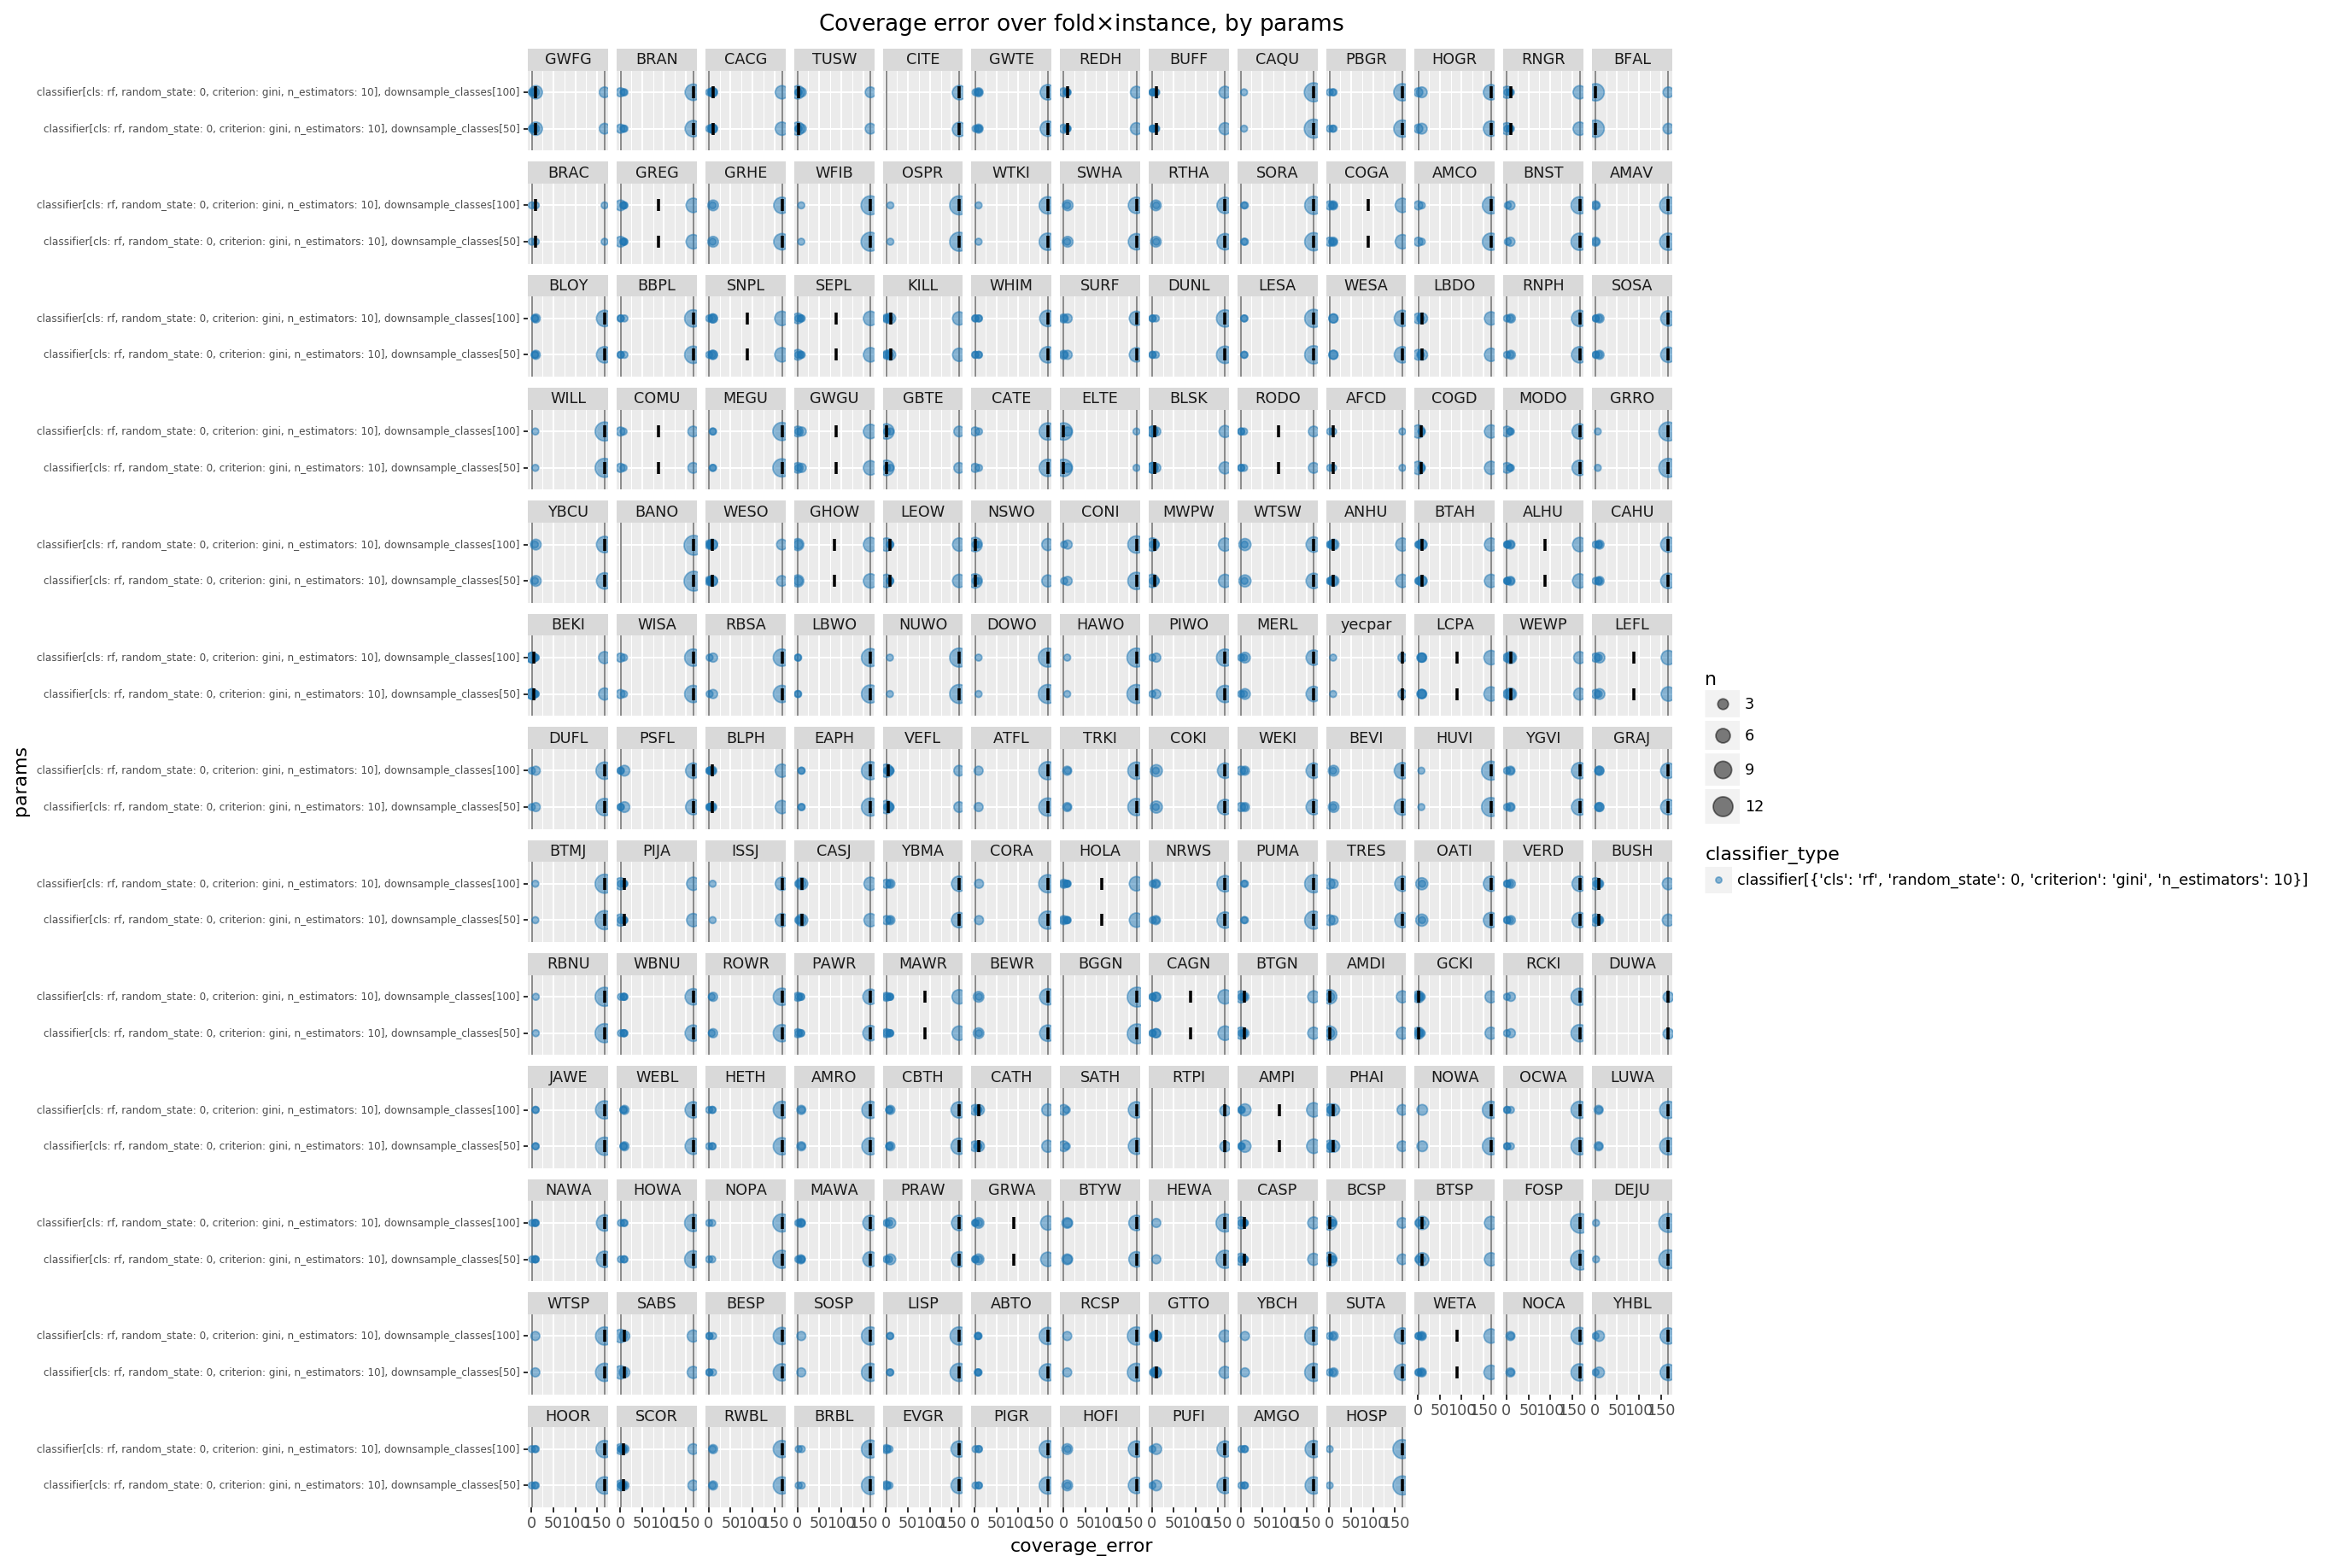

<ggplot: (8740527486605)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_list))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = -1
params = param_list[params_i]
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'

models:
  params[-1/2]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'
  fold[*/3]


In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,object,1096722,1914,1914,3,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[1]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[2]"
params,object,765600,1914,1914,1,NaN,NaN,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]"
classifier_type,object,914892,1914,1914,1,NaN,NaN,"classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]"
fold,int64,51040,1914,1914,3,NaN,NaN,0,0,1,2,2
i,int64,53588,1914,1914,1561,NaN,NaN,0,798,1595,2391,3183
y_true,object,162804,1914,1914,166,NaN,NaN,ABTO,CATH,KILL,RNGR,yecpar
coverage_error,float64,45936,1914,1914,9,NaN,NaN,1,9,167,167,167


,model_id,params,classifier_type,fold,i,y_true,coverage_error
1914,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2937,WETA,167.0
1915,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1405,yecpar,9.0
1916,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2073,MAWR,167.0
1917,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,56,CACG,8.0
1918,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2798,SOSP,167.0
1919,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2759,SABS,167.0
1920,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1280,RBSA,167.0
1921,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2310,CBTH,9.0
1922,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,2053,PAWR,167.0
1923,"classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]","classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]","classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]",0,1125,MWPW,1.0


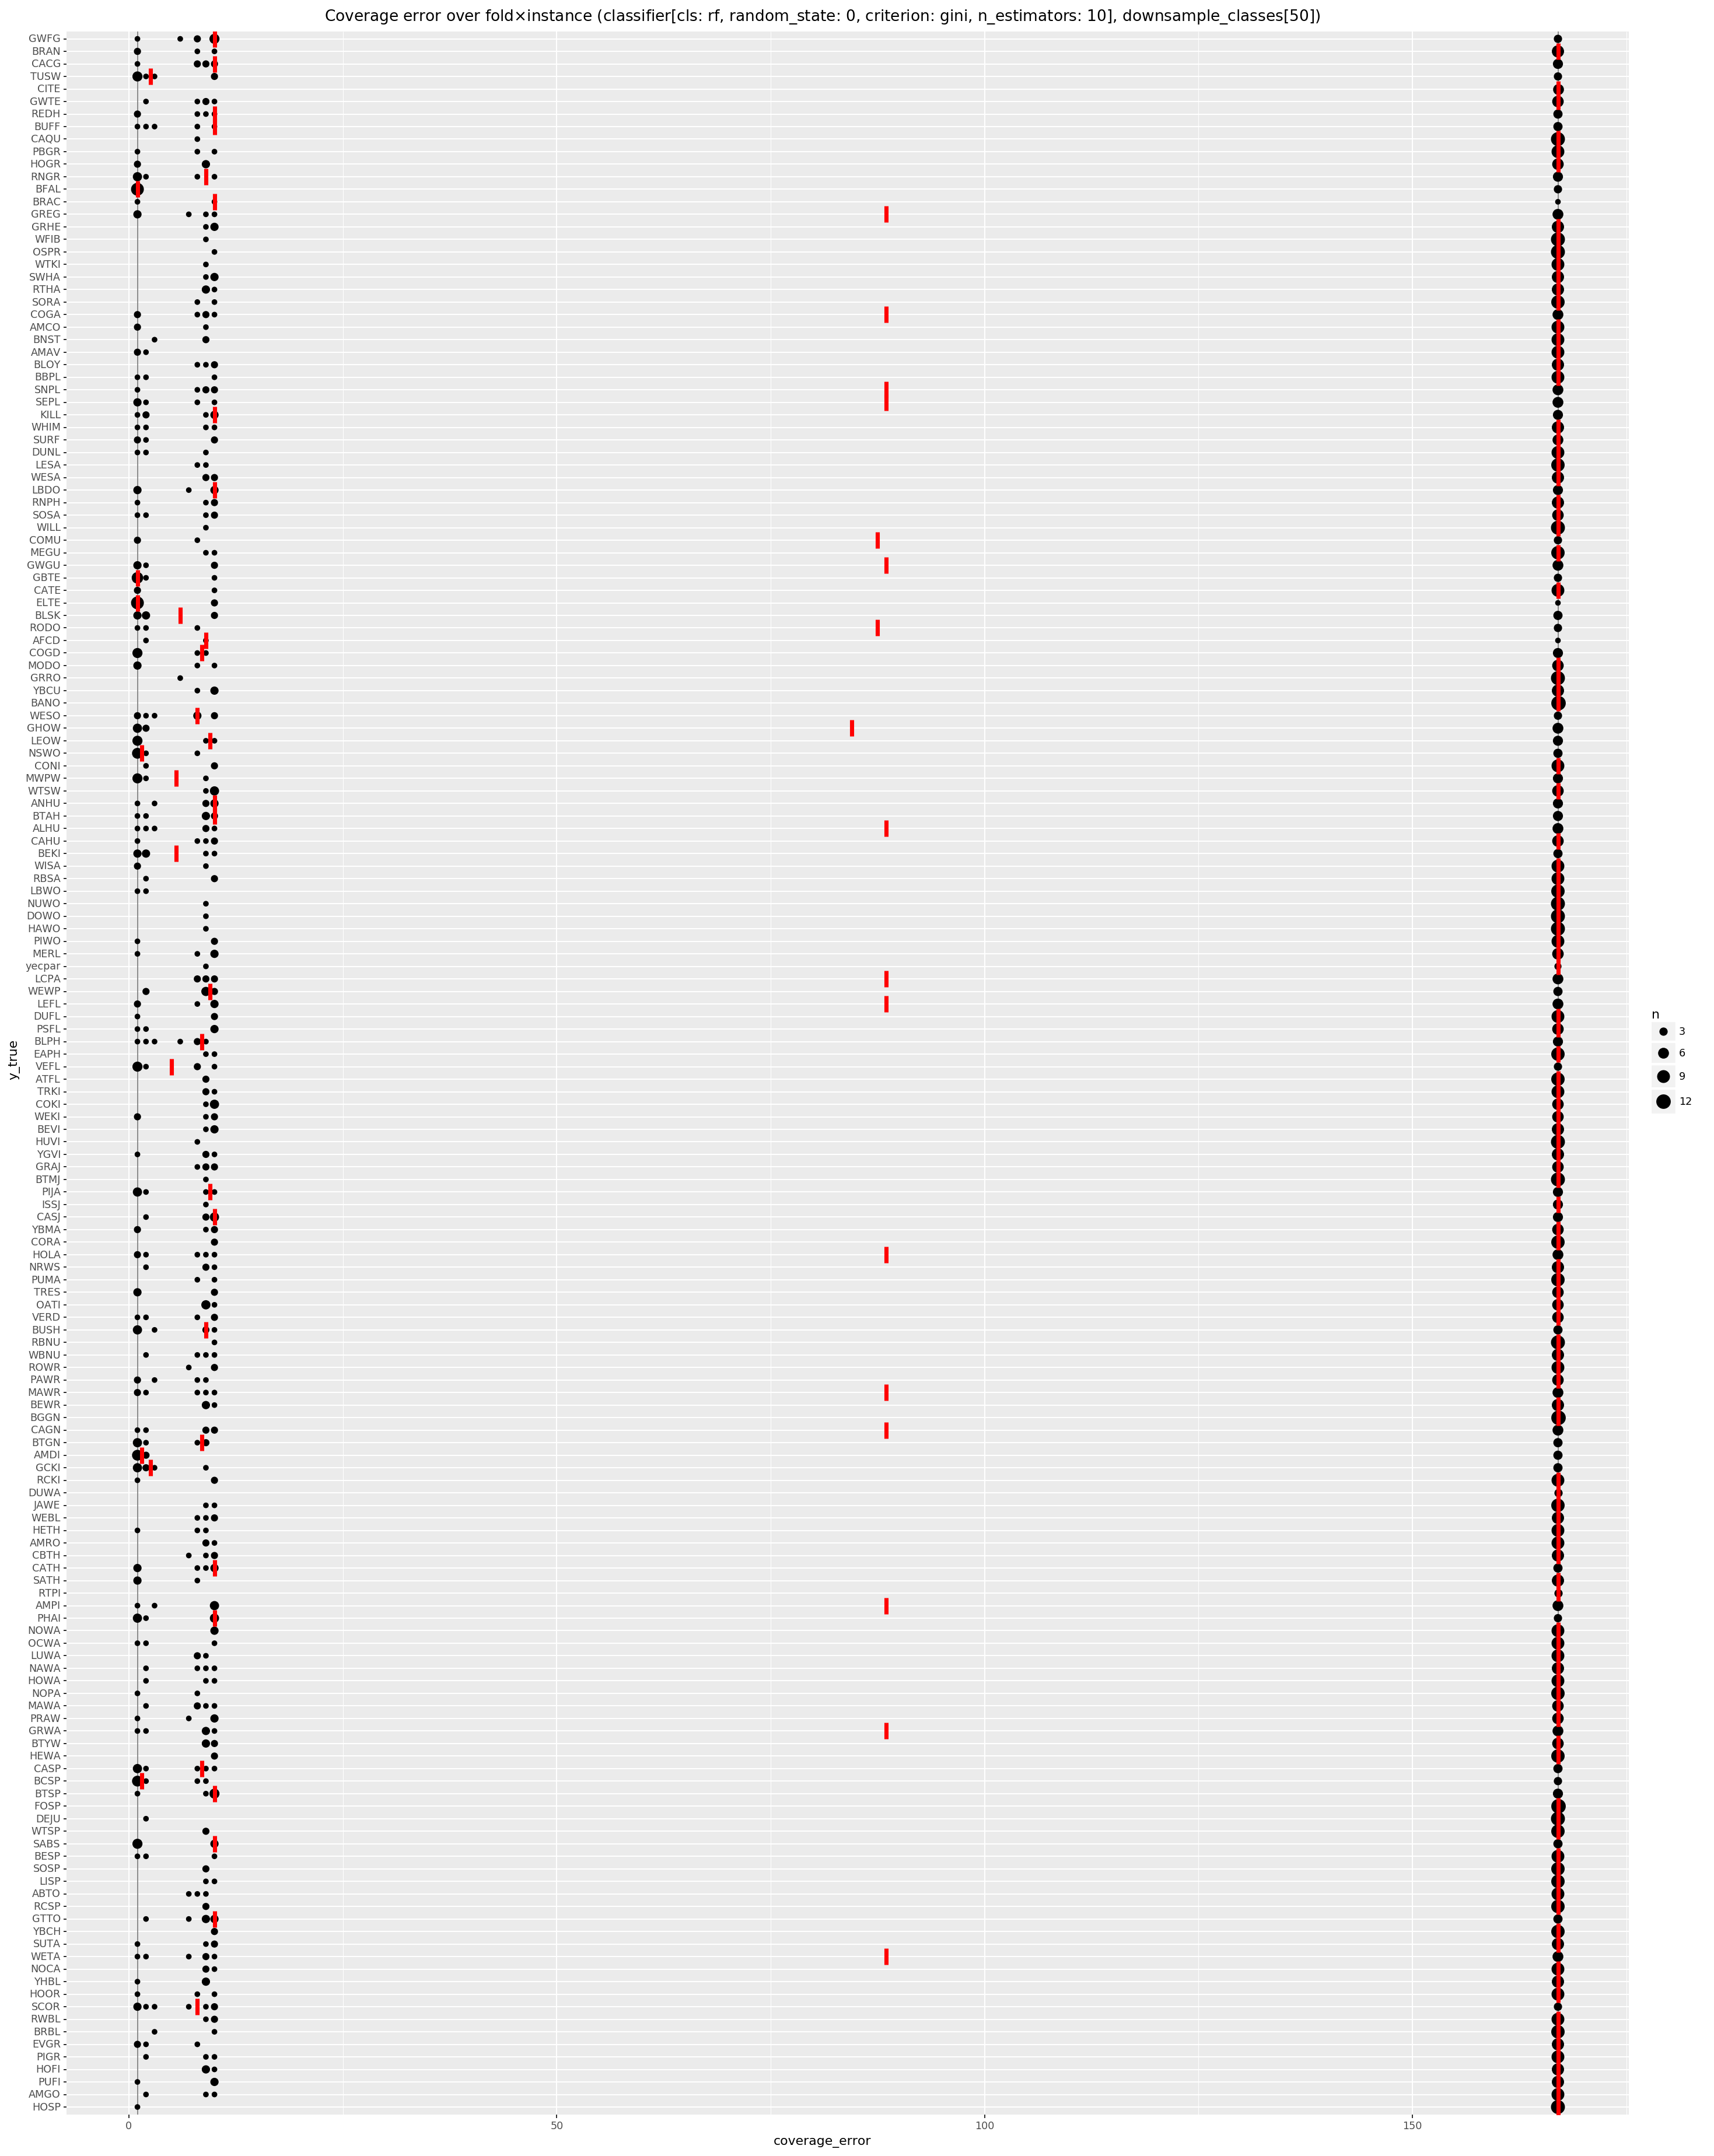

<ggplot: (8740518369782)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

/app/viz.py:195: RuntimeWarning: invalid value encountered in true_divide
  M = M.astype('float') / M.sum(axis=1)[:, np.newaxis]


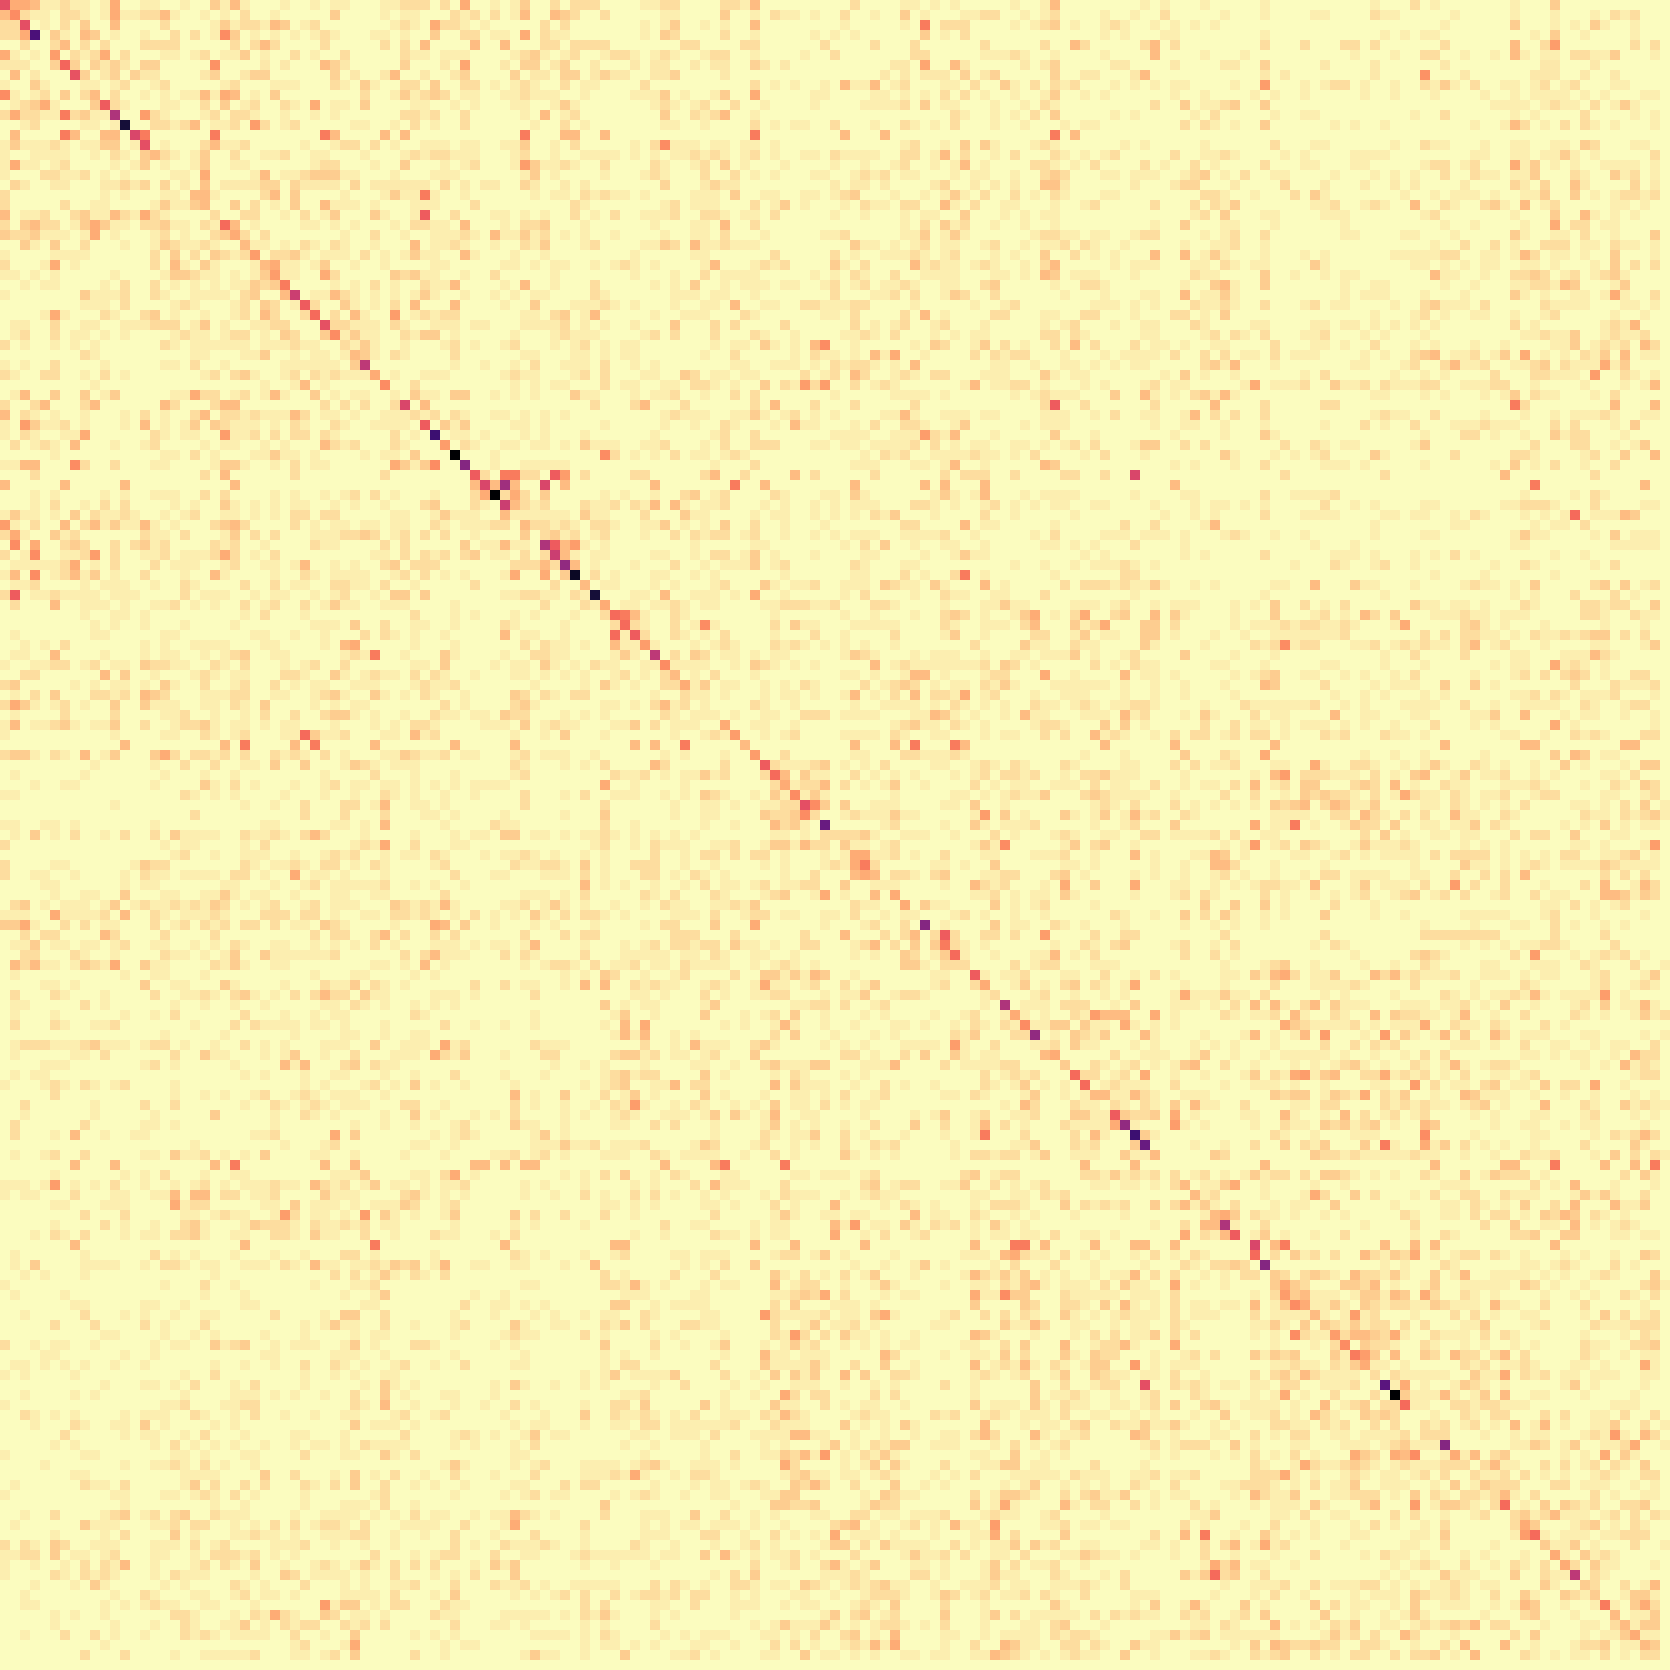

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_list[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[100]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'

model:
  params[-1/2]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]'
  fold[0/3]

model_id                      classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50], fold[0]
params                                 classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 10], downsample_classes[50]
params_dict        {'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}, 'downsample_classes': 50}
classifier_type                                  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 10}]
fold                                                                                                      

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
    )

[skip]